In [1]:
import numpy as np
import random
import copy
import time
import math
import sys
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
%matplotlib inline

### Hyper-parameters
* BUFFER_SIZE - experience replay buffer size
* BATCH_SIZE - minibatch size to retirieve from experience replay
* GAMMA - discount rate
* TAU - parameter for soft update that determines how fast target network is merged into local
* LR_ACTOR - learning rate for actor network
* LR_CRITIC - learning rate for critic network
* WEIGHT_DECAY - L2 regularization weight decay factor
* LEARN_EVERY - determines timestep interval to learn networks
* LEARN_NUM - number of learning procedures 
* OU_SIGMA - Ornstein-Uhlenbeck noise parameter
* OU_THETA - Ornstein-Uhlenbeck noise parameter
* EPSILON - parameter that controls noice effect for exploration/exploitation (not enabled in this example)
* EPSILON_DECAY - decay rate for EPSILON (not enabled in this example)

In [2]:
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 2e-1
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
WEIGHT_DECAY = 0
LEARN_EVERY = 1
LEARN_NUM = 1
OU_SIGMA = 0.2
OU_THETA = 0.15
EPSILON = 1.0
EPSILON_DECAY = 1e-6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Utility that helps to implement Ornstein-Uhlenbeck noise for better exproration.

In [3]:
class OUNoise:
    def __init__(self, size, seed, mu=0., theta=OU_THETA, sigma=OU_SIGMA):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx

        return self.state

Experience replay buffer implementation that stores and generates tuples for network training.

In [4]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

PyTorch neural networks implementations for Actor and Critic. They will be used in other classes later on.

In [5]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)

    return (-lim, lim)


class ActorNN(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=512, fc2_units=256):
        super(ActorNN, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))

        return F.tanh(self.fc3(x))


class CriticNN(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=512, fc2_units=256):
        super(CriticNN, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))

        return self.fc3(x)

An Actor class that learns a policy. Each of the agent's in the environment has its own Actor. 
It shared experience replay memory with ather Actors.

In [6]:
class Actor(object):
    def __init__(self, state_size, action_size, memory, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = EPSILON

        # actor networks
        self.local = ActorNN(state_size, action_size, random_seed).to(device)
        self.target = ActorNN(state_size, action_size, random_seed).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=LR_ACTOR)

        self.noise = OUNoise(action_size, random_seed)

        self.memory = memory

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.local.eval()
        with torch.no_grad():
            action = self.local(state).cpu().data.numpy()
        self.local.train()
        if add_noise:
            #action += self.epsilon * self.noise.sample()
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

A Critic class that implements the actual learning of 2 Actors and implement the actual DDPG algorith:
* step 1: getting predicted next-state actions and Q values from target models
* step 2: computing Q targets for current states 
* step 3: computing critic loss
* step 4: minimizing critic loss and traing the network
* step 5: computing actor loss (with '-' sign as this is gradient ascent
* step 6: minimizing actor loss and traing the network
* step 7: applying soft update and slowly mering local networks into target

In [7]:
class Critic(object):
    def __init__(self, state_size, action_size, memory, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = EPSILON

        # critic networks
        self.local = CriticNN(state_size, action_size, random_seed).to(device)
        self.target = CriticNN(state_size, action_size, random_seed).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        self.memory = memory

    def learn(self, actor, experiences):
        states, actions, rewards, next_states, dones = experiences

        # critic update
        # step 1:
        actions_next = actor.target(next_states)
        Q_targets_next = self.target(next_states, actions_next)
        # step 2:
        Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
        # step 3:
        Q_expected = self.local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # step 4:
        self.optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.optimizer.step()

        # actor update
        # step 5:
        actions_pred = actor.local(states)
        actor_loss = -self.local(states, actions_pred).mean()
        # step 6:
        actor.optimizer.zero_grad()
        actor_loss.backward()
        actor.optimizer.step()

        # step 7:
        self.soft_update(self.local, self.target, TAU)
        self.soft_update(actor.local, actor.target, TAU)

        # ---------------------------- update noise ---------------------------- #
        #self.epsilon -= EPSILON_DECAY
        #self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

AgenrManager is a helper class that encapsulates the functionality for working with Actors and a Critic. It also hold main exprience replay memory and shares it across all Actors.

In [8]:
class AgentManager:
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.num_agents = num_agents

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

        self.actors = [Actor(state_size, action_size, self.memory, random_seed) for _ in range(num_agents)]
        self.critic = Critic(state_size, action_size, self.memory, random_seed)

    def load_models(self):
        for i, actor in enumerate(self.actors):
            actor.local.load_state_dict(torch.load("actor_model_{}.pth".format(i+1)))

    def reset(self):
        for actor in self.actors:
            actor.reset()

    def act(self, states, add_noise=True):
        actions = [actor.act(np.expand_dims(states, axis=0), add_noise) for actor, states in zip(self.actors, states)]

        return actions

    def step(self, states, actions, rewards, next_states, dones, timestep):
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        for actor in self.actors:
            if len(self.memory) > BATCH_SIZE and timestep % LEARN_EVERY == 0:
                for _ in range(LEARN_NUM):
                    experiences = self.memory.sample()

                    self.critic.learn(actor, experiences)

A utility function that initiates Unity environment, an agent and starts the training.

In [9]:
def ddpg(n_episodes=2000, max_steps=500, solved_score=0.5, max_last_scores=100,
         actor_path='actor_model_{}.pth', critic_path='critic_model.pth'):

    last_scores = []
    all_scores = []
    for _ in range(num_agents):
        last_scores.append(deque(maxlen=max_last_scores))
        all_scores.append([])
    #all_scores = []

    max_last_average_score = -math.inf

    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent_manager.reset()

        for t in range(max_steps):
            actions = agent_manager.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent_manager.step(states, actions, rewards, next_states, dones, t)

            states = next_states
            scores += rewards

            if np.any(dones):
                break

        scores_string = "average scores: "
        for i in range(num_agents):
            average_score = np.mean(scores[i])

            last_scores[i].append(average_score)
            all_scores[i].append(average_score)

            last_average_score = np.mean(last_scores[i])

            scores_string += "agent {} - {:.2f}, ".format(i, last_average_score)

            if last_average_score > max_last_average_score:
                max_last_average_score = last_average_score

        print("\repisode {}/{}, max score: {:.2f}, {}".format(
            i_episode, n_episodes, max_last_average_score, scores_string), end="")
        sys.stdout.flush()

        if max_last_average_score >= solved_score:
            print("\nsolved in {} episodes".format(i_episode))

            torch.save(agent_manager.actors[0].local.state_dict(), actor_path.format("1"))
            torch.save(agent_manager.actors[1].local.state_dict(), actor_path.format("2"))
            torch.save(agent_manager.critic.local.state_dict(), critic_path)

            plt.figure()

            lines = []
            lines.append(plt.plot(all_scores[0], color="green", label="agent 1")[0])
            lines.append(plt.plot(all_scores[1], color="red", label="agent 2")[0])

            plt.legend(handles=lines, loc=2)
            plt.ylabel("score")
            plt.xlabel("episode #")
            plt.show()

            break

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


episode 1/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - -0.01, 

episode 2/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - -0.01, 

/home/mexxik/.virtualenvs/drl-project-3/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


episode 3/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - -0.01, 

episode 4/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - -0.01, 

episode 5/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - -0.01, 

episode 6/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 7/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 8/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 9/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 10/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 11/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 12/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 13/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 14/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 15/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 16/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 17/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 18/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 19/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 20/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 21/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 22/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 23/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 24/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 25/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 26/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 27/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 28/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 29/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 30/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 31/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 32/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 33/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 34/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 35/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.01, 

episode 36/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 37/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 38/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 39/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 40/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 41/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 42/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 43/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 44/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 45/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 46/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 47/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 48/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 49/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 50/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 51/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 52/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 53/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 54/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 55/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 56/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 57/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 58/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 59/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 60/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 61/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 62/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 63/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 64/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 65/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 66/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 67/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 68/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 69/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 70/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 71/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 72/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 73/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 74/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 75/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 76/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 77/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 78/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 79/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 80/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 81/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 82/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 83/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 84/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 85/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 86/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - -0.00, 

episode 87/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - 0.00, 

episode 88/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - 0.00, 

episode 89/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - 0.00, 

episode 90/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - 0.00, 

episode 91/2000, max score: 0.00, average scores: agent 0 - -0.00, agent 1 - 0.00, 

episode 92/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - 0.00, 

episode 93/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - 0.00, 

episode 94/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - 0.00, 

episode 95/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - 0.00, 

episode 96/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - 0.00, 

episode 97/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - 0.00, 

episode 98/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - 0.00, 

episode 99/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - 0.00, 

episode 100/2000, max score: 0.00, average scores: agent 0 - 0.00, agent 1 - 0.00, 

episode 101/2000, max score: 0.01, average scores: agent 0 - 0.00, agent 1 - 0.01, 

episode 102/2000, max score: 0.01, average scores: agent 0 - 0.00, agent 1 - 0.01, 

episode 103/2000, max score: 0.01, average scores: agent 0 - 0.00, agent 1 - 0.01, 

episode 104/2000, max score: 0.01, average scores: agent 0 - 0.00, agent 1 - 0.01, 

episode 105/2000, max score: 0.01, average scores: agent 0 - 0.00, agent 1 - 0.01, 

episode 106/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.00, 

episode 107/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 108/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 109/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 110/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 111/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 112/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 113/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 114/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 115/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 116/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 117/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 118/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 119/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 120/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 121/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 122/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 123/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 124/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 125/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 126/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 127/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 128/2000, max score: 0.01, average scores: agent 0 - 0.01, agent 1 - 0.01, 

episode 129/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.01, 

episode 130/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 131/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 132/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 133/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 134/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 135/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 136/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 137/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 138/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 139/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 140/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 141/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 142/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 143/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 144/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 145/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 146/2000, max score: 0.02, average scores: agent 0 - 0.02, agent 1 - 0.02, 

episode 147/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 148/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 149/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 150/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 151/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 152/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 153/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 154/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 155/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 156/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 157/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 158/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 159/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 160/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 161/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.02, 

episode 162/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.03, 

episode 163/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.03, 

episode 164/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.03, 

episode 165/2000, max score: 0.03, average scores: agent 0 - 0.03, agent 1 - 0.03, 

episode 166/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 167/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 168/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 169/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 170/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 171/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 172/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 173/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 174/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 175/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 176/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 177/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 178/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 179/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 180/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 181/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 182/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 183/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.03, 

episode 184/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.04, 

episode 185/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.04, 

episode 186/2000, max score: 0.04, average scores: agent 0 - 0.04, agent 1 - 0.04, 

episode 187/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 188/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 189/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 190/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 191/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 192/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 193/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 194/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 195/2000, max score: 0.05, average scores: agent 0 - 0.04, agent 1 - 0.04, 

episode 196/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 197/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 198/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 199/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 200/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 201/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 202/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 203/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 204/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 205/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 206/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 207/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 208/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 209/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 210/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 211/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 212/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.04, 

episode 213/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 214/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 215/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 216/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 217/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 218/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 219/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 220/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 221/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 222/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 223/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 224/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 225/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 226/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 227/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 228/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 229/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 230/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 231/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 232/2000, max score: 0.05, average scores: agent 0 - 0.04, agent 1 - 0.05, 

episode 233/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 234/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 235/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 236/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 237/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 238/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 239/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 240/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 241/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 242/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 243/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 244/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 245/2000, max score: 0.05, average scores: agent 0 - 0.05, agent 1 - 0.05, 

episode 246/2000, max score: 0.06, average scores: agent 0 - 0.05, agent 1 - 0.06, 

episode 247/2000, max score: 0.07, average scores: agent 0 - 0.06, agent 1 - 0.07, 

episode 248/2000, max score: 0.07, average scores: agent 0 - 0.06, agent 1 - 0.07, 

episode 249/2000, max score: 0.07, average scores: agent 0 - 0.06, agent 1 - 0.07, 

episode 250/2000, max score: 0.07, average scores: agent 0 - 0.06, agent 1 - 0.07, 

episode 251/2000, max score: 0.07, average scores: agent 0 - 0.06, agent 1 - 0.07, 

episode 252/2000, max score: 0.07, average scores: agent 0 - 0.06, agent 1 - 0.07, 

episode 253/2000, max score: 0.07, average scores: agent 0 - 0.06, agent 1 - 0.07, 

episode 254/2000, max score: 0.07, average scores: agent 0 - 0.06, agent 1 - 0.07, 

episode 255/2000, max score: 0.07, average scores: agent 0 - 0.06, agent 1 - 0.07, 

episode 256/2000, max score: 0.07, average scores: agent 0 - 0.06, agent 1 - 0.07, 

episode 257/2000, max score: 0.07, average scores: agent 0 - 0.05, agent 1 - 0.07, 

episode 258/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 259/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 260/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 261/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 262/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 263/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 264/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 265/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 266/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 267/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 268/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 269/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 270/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 271/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 272/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 273/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 274/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 275/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 276/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 277/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 278/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 279/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 280/2000, max score: 0.08, average scores: agent 0 - 0.07, agent 1 - 0.08, 

episode 281/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 282/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 283/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 284/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 285/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 286/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 287/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 288/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 289/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 290/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 291/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 292/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 293/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 294/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 295/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 296/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 297/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 298/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 299/2000, max score: 0.08, average scores: agent 0 - 0.06, agent 1 - 0.08, 

episode 300/2000, max score: 0.09, average scores: agent 0 - 0.06, agent 1 - 0.09, 

episode 301/2000, max score: 0.09, average scores: agent 0 - 0.06, agent 1 - 0.09, 

episode 302/2000, max score: 0.09, average scores: agent 0 - 0.06, agent 1 - 0.09, 

episode 303/2000, max score: 0.09, average scores: agent 0 - 0.06, agent 1 - 0.09, 

episode 304/2000, max score: 0.09, average scores: agent 0 - 0.06, agent 1 - 0.09, 

episode 305/2000, max score: 0.09, average scores: agent 0 - 0.06, agent 1 - 0.09, 

episode 306/2000, max score: 0.09, average scores: agent 0 - 0.07, agent 1 - 0.09, 

episode 307/2000, max score: 0.09, average scores: agent 0 - 0.07, agent 1 - 0.09, 

episode 308/2000, max score: 0.09, average scores: agent 0 - 0.07, agent 1 - 0.09, 

episode 309/2000, max score: 0.09, average scores: agent 0 - 0.07, agent 1 - 0.09, 

episode 310/2000, max score: 0.09, average scores: agent 0 - 0.07, agent 1 - 0.09, 

episode 311/2000, max score: 0.09, average scores: agent 0 - 0.07, agent 1 - 0.09, 

episode 312/2000, max score: 0.10, average scores: agent 0 - 0.08, agent 1 - 0.10, 

episode 313/2000, max score: 0.10, average scores: agent 0 - 0.07, agent 1 - 0.09, 

episode 314/2000, max score: 0.10, average scores: agent 0 - 0.07, agent 1 - 0.09, 

episode 315/2000, max score: 0.10, average scores: agent 0 - 0.07, agent 1 - 0.09, 

episode 316/2000, max score: 0.10, average scores: agent 0 - 0.07, agent 1 - 0.09, 

episode 317/2000, max score: 0.10, average scores: agent 0 - 0.08, agent 1 - 0.10, 

episode 318/2000, max score: 0.10, average scores: agent 0 - 0.08, agent 1 - 0.10, 

episode 319/2000, max score: 0.10, average scores: agent 0 - 0.08, agent 1 - 0.10, 

episode 320/2000, max score: 0.10, average scores: agent 0 - 0.08, agent 1 - 0.10, 

episode 321/2000, max score: 0.10, average scores: agent 0 - 0.08, agent 1 - 0.10, 

episode 322/2000, max score: 0.10, average scores: agent 0 - 0.08, agent 1 - 0.10, 

episode 323/2000, max score: 0.11, average scores: agent 0 - 0.09, agent 1 - 0.11, 

episode 324/2000, max score: 0.11, average scores: agent 0 - 0.10, agent 1 - 0.11, 

episode 325/2000, max score: 0.12, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 326/2000, max score: 0.12, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 327/2000, max score: 0.12, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 328/2000, max score: 0.12, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 329/2000, max score: 0.12, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 330/2000, max score: 0.12, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 331/2000, max score: 0.12, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 332/2000, max score: 0.12, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 333/2000, max score: 0.12, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 334/2000, max score: 0.12, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 335/2000, max score: 0.12, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 336/2000, max score: 0.12, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 337/2000, max score: 0.12, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 338/2000, max score: 0.12, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 339/2000, max score: 0.12, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 340/2000, max score: 0.12, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 341/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 342/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 343/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 344/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 345/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 346/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 347/2000, max score: 0.13, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 348/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 349/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 350/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 351/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 352/2000, max score: 0.13, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 353/2000, max score: 0.13, average scores: agent 0 - 0.10, agent 1 - 0.12, 

episode 354/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 355/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 356/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 357/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 358/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 359/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.12, 

episode 360/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 361/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 362/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 363/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 364/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 365/2000, max score: 0.13, average scores: agent 0 - 0.11, agent 1 - 0.13, 

episode 366/2000, max score: 0.14, average scores: agent 0 - 0.12, agent 1 - 0.14, 

episode 367/2000, max score: 0.14, average scores: agent 0 - 0.12, agent 1 - 0.14, 

episode 368/2000, max score: 0.14, average scores: agent 0 - 0.12, agent 1 - 0.14, 

episode 369/2000, max score: 0.14, average scores: agent 0 - 0.12, agent 1 - 0.14, 

episode 370/2000, max score: 0.14, average scores: agent 0 - 0.12, agent 1 - 0.14, 

episode 371/2000, max score: 0.14, average scores: agent 0 - 0.12, agent 1 - 0.14, 

episode 372/2000, max score: 0.14, average scores: agent 0 - 0.12, agent 1 - 0.14, 

episode 373/2000, max score: 0.14, average scores: agent 0 - 0.12, agent 1 - 0.14, 

episode 374/2000, max score: 0.14, average scores: agent 0 - 0.12, agent 1 - 0.14, 

episode 375/2000, max score: 0.14, average scores: agent 0 - 0.12, agent 1 - 0.14, 

episode 376/2000, max score: 0.14, average scores: agent 0 - 0.13, agent 1 - 0.14, 

episode 377/2000, max score: 0.15, average scores: agent 0 - 0.13, agent 1 - 0.15, 

episode 378/2000, max score: 0.15, average scores: agent 0 - 0.14, agent 1 - 0.15, 

episode 379/2000, max score: 0.15, average scores: agent 0 - 0.14, agent 1 - 0.15, 

episode 380/2000, max score: 0.15, average scores: agent 0 - 0.14, agent 1 - 0.15, 

episode 381/2000, max score: 0.15, average scores: agent 0 - 0.14, agent 1 - 0.15, 

episode 382/2000, max score: 0.15, average scores: agent 0 - 0.14, agent 1 - 0.15, 

episode 383/2000, max score: 0.15, average scores: agent 0 - 0.14, agent 1 - 0.15, 

episode 384/2000, max score: 0.15, average scores: agent 0 - 0.14, agent 1 - 0.15, 

episode 385/2000, max score: 0.16, average scores: agent 0 - 0.15, agent 1 - 0.16, 

episode 386/2000, max score: 0.16, average scores: agent 0 - 0.15, agent 1 - 0.16, 

episode 387/2000, max score: 0.16, average scores: agent 0 - 0.15, agent 1 - 0.16, 

episode 388/2000, max score: 0.16, average scores: agent 0 - 0.15, agent 1 - 0.16, 

episode 389/2000, max score: 0.17, average scores: agent 0 - 0.16, agent 1 - 0.17, 

episode 390/2000, max score: 0.17, average scores: agent 0 - 0.16, agent 1 - 0.17, 

episode 391/2000, max score: 0.17, average scores: agent 0 - 0.16, agent 1 - 0.17, 

episode 392/2000, max score: 0.17, average scores: agent 0 - 0.17, agent 1 - 0.17, 

episode 393/2000, max score: 0.17, average scores: agent 0 - 0.17, agent 1 - 0.17, 

episode 394/2000, max score: 0.17, average scores: agent 0 - 0.17, agent 1 - 0.17, 

episode 395/2000, max score: 0.18, average scores: agent 0 - 0.18, agent 1 - 0.18, 

episode 396/2000, max score: 0.18, average scores: agent 0 - 0.18, agent 1 - 0.18, 

episode 397/2000, max score: 0.19, average scores: agent 0 - 0.19, agent 1 - 0.19, 

episode 398/2000, max score: 0.20, average scores: agent 0 - 0.20, agent 1 - 0.20, 

episode 399/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 400/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 401/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 402/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 403/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 404/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 405/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 406/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 407/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 408/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 409/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 410/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 411/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 412/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 413/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.20, 

episode 414/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 415/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 416/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 417/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 418/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 419/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 420/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 421/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 422/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 423/2000, max score: 0.21, average scores: agent 0 - 0.20, agent 1 - 0.20, 

episode 424/2000, max score: 0.21, average scores: agent 0 - 0.19, agent 1 - 0.20, 

episode 425/2000, max score: 0.21, average scores: agent 0 - 0.19, agent 1 - 0.19, 

episode 426/2000, max score: 0.21, average scores: agent 0 - 0.19, agent 1 - 0.19, 

episode 427/2000, max score: 0.21, average scores: agent 0 - 0.19, agent 1 - 0.19, 

episode 428/2000, max score: 0.21, average scores: agent 0 - 0.19, agent 1 - 0.19, 

episode 429/2000, max score: 0.21, average scores: agent 0 - 0.20, agent 1 - 0.20, 

episode 430/2000, max score: 0.21, average scores: agent 0 - 0.19, agent 1 - 0.20, 

episode 431/2000, max score: 0.21, average scores: agent 0 - 0.20, agent 1 - 0.20, 

episode 432/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 433/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 434/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 435/2000, max score: 0.21, average scores: agent 0 - 0.21, agent 1 - 0.21, 

episode 436/2000, max score: 0.22, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 437/2000, max score: 0.22, average scores: agent 0 - 0.22, agent 1 - 0.21, 

episode 438/2000, max score: 0.22, average scores: agent 0 - 0.22, agent 1 - 0.21, 

episode 439/2000, max score: 0.22, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 440/2000, max score: 0.22, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 441/2000, max score: 0.22, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 442/2000, max score: 0.23, average scores: agent 0 - 0.22, agent 1 - 0.23, 

episode 443/2000, max score: 0.23, average scores: agent 0 - 0.22, agent 1 - 0.23, 

episode 444/2000, max score: 0.23, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 445/2000, max score: 0.23, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 446/2000, max score: 0.23, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 447/2000, max score: 0.25, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 448/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 449/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 450/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 451/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 452/2000, max score: 0.25, average scores: agent 0 - 0.25, agent 1 - 0.24, 

episode 453/2000, max score: 0.25, average scores: agent 0 - 0.25, agent 1 - 0.24, 

episode 454/2000, max score: 0.25, average scores: agent 0 - 0.25, agent 1 - 0.24, 

episode 455/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 456/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 457/2000, max score: 0.25, average scores: agent 0 - 0.25, agent 1 - 0.24, 

episode 458/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 459/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 460/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 461/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 462/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 463/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 464/2000, max score: 0.25, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 465/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 466/2000, max score: 0.25, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 467/2000, max score: 0.25, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 468/2000, max score: 0.26, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 469/2000, max score: 0.26, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 470/2000, max score: 0.26, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 471/2000, max score: 0.26, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 472/2000, max score: 0.26, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 473/2000, max score: 0.26, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 474/2000, max score: 0.27, average scores: agent 0 - 0.27, agent 1 - 0.26, 

episode 475/2000, max score: 0.27, average scores: agent 0 - 0.27, agent 1 - 0.26, 

episode 476/2000, max score: 0.27, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 477/2000, max score: 0.27, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 478/2000, max score: 0.27, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 479/2000, max score: 0.27, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 480/2000, max score: 0.27, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 481/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.26, 

episode 482/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.26, 

episode 483/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.26, 

episode 484/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.26, 

episode 485/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 486/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 487/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 488/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.26, 

episode 489/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 490/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 491/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 492/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 493/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 494/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 495/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 496/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 497/2000, max score: 0.27, average scores: agent 0 - 0.23, agent 1 - 0.24, 

episode 498/2000, max score: 0.27, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 499/2000, max score: 0.27, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 500/2000, max score: 0.27, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 501/2000, max score: 0.27, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 502/2000, max score: 0.27, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 503/2000, max score: 0.27, average scores: agent 0 - 0.23, agent 1 - 0.24, 

episode 504/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 505/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 506/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 507/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 508/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 509/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 510/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 511/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 512/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 513/2000, max score: 0.27, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 514/2000, max score: 0.27, average scores: agent 0 - 0.25, agent 1 - 0.26, 

episode 515/2000, max score: 0.27, average scores: agent 0 - 0.26, agent 1 - 0.27, 

episode 516/2000, max score: 0.27, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 517/2000, max score: 0.27, average scores: agent 0 - 0.26, agent 1 - 0.27, 

episode 518/2000, max score: 0.27, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 519/2000, max score: 0.27, average scores: agent 0 - 0.26, agent 1 - 0.27, 

episode 520/2000, max score: 0.27, average scores: agent 0 - 0.26, agent 1 - 0.27, 

episode 521/2000, max score: 0.27, average scores: agent 0 - 0.27, agent 1 - 0.27, 

episode 522/2000, max score: 0.28, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 523/2000, max score: 0.28, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 524/2000, max score: 0.29, average scores: agent 0 - 0.29, agent 1 - 0.29, 

episode 525/2000, max score: 0.30, average scores: agent 0 - 0.29, agent 1 - 0.30, 

episode 526/2000, max score: 0.30, average scores: agent 0 - 0.30, agent 1 - 0.30, 

episode 527/2000, max score: 0.31, average scores: agent 0 - 0.31, agent 1 - 0.31, 

episode 528/2000, max score: 0.32, average scores: agent 0 - 0.31, agent 1 - 0.32, 

episode 529/2000, max score: 0.32, average scores: agent 0 - 0.32, agent 1 - 0.32, 

episode 530/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.34, 

episode 531/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.33, 

episode 532/2000, max score: 0.34, average scores: agent 0 - 0.32, agent 1 - 0.33, 

episode 533/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.34, 

episode 534/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.34, 

episode 535/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.34, 

episode 536/2000, max score: 0.34, average scores: agent 0 - 0.32, agent 1 - 0.33, 

episode 537/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.34, 

episode 538/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.34, 

episode 539/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.34, 

episode 540/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.34, 

episode 541/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.34, 

episode 542/2000, max score: 0.34, average scores: agent 0 - 0.32, agent 1 - 0.33, 

episode 543/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.34, 

episode 544/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.33, 

episode 545/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.33, 

episode 546/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.33, 

episode 547/2000, max score: 0.34, average scores: agent 0 - 0.32, agent 1 - 0.32, 

episode 548/2000, max score: 0.34, average scores: agent 0 - 0.32, agent 1 - 0.32, 

episode 549/2000, max score: 0.34, average scores: agent 0 - 0.32, agent 1 - 0.33, 

episode 550/2000, max score: 0.34, average scores: agent 0 - 0.32, agent 1 - 0.33, 

episode 551/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.33, 

episode 552/2000, max score: 0.34, average scores: agent 0 - 0.33, agent 1 - 0.33, 

episode 553/2000, max score: 0.34, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 554/2000, max score: 0.35, average scores: agent 0 - 0.34, agent 1 - 0.35, 

episode 555/2000, max score: 0.36, average scores: agent 0 - 0.35, agent 1 - 0.36, 

episode 556/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.37, 

episode 557/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.37, 

episode 558/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.37, 

episode 559/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.37, 

episode 560/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.37, 

episode 561/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.37, 

episode 562/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.36, 

episode 563/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.36, 

episode 564/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.36, 

episode 565/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.36, 

episode 566/2000, max score: 0.37, average scores: agent 0 - 0.37, agent 1 - 0.37, 

episode 567/2000, max score: 0.37, average scores: agent 0 - 0.35, agent 1 - 0.36, 

episode 568/2000, max score: 0.37, average scores: agent 0 - 0.35, agent 1 - 0.35, 

episode 569/2000, max score: 0.37, average scores: agent 0 - 0.34, agent 1 - 0.35, 

episode 570/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.36, 

episode 571/2000, max score: 0.37, average scores: agent 0 - 0.35, agent 1 - 0.36, 

episode 572/2000, max score: 0.37, average scores: agent 0 - 0.35, agent 1 - 0.36, 

episode 573/2000, max score: 0.37, average scores: agent 0 - 0.35, agent 1 - 0.36, 

episode 574/2000, max score: 0.37, average scores: agent 0 - 0.35, agent 1 - 0.36, 

episode 575/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.37, 

episode 576/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.37, 

episode 577/2000, max score: 0.37, average scores: agent 0 - 0.36, agent 1 - 0.37, 

episode 578/2000, max score: 0.38, average scores: agent 0 - 0.36, agent 1 - 0.38, 

episode 579/2000, max score: 0.38, average scores: agent 0 - 0.36, agent 1 - 0.37, 

episode 580/2000, max score: 0.38, average scores: agent 0 - 0.37, agent 1 - 0.38, 

episode 581/2000, max score: 0.39, average scores: agent 0 - 0.37, agent 1 - 0.39, 

episode 582/2000, max score: 0.39, average scores: agent 0 - 0.38, agent 1 - 0.39, 

episode 583/2000, max score: 0.39, average scores: agent 0 - 0.38, agent 1 - 0.39, 

episode 584/2000, max score: 0.40, average scores: agent 0 - 0.39, agent 1 - 0.40, 

episode 585/2000, max score: 0.40, average scores: agent 0 - 0.39, agent 1 - 0.40, 

episode 586/2000, max score: 0.41, average scores: agent 0 - 0.40, agent 1 - 0.41, 

episode 587/2000, max score: 0.42, average scores: agent 0 - 0.41, agent 1 - 0.42, 

episode 588/2000, max score: 0.42, average scores: agent 0 - 0.41, agent 1 - 0.42, 

episode 589/2000, max score: 0.42, average scores: agent 0 - 0.41, agent 1 - 0.42, 

episode 590/2000, max score: 0.42, average scores: agent 0 - 0.41, agent 1 - 0.42, 

episode 591/2000, max score: 0.43, average scores: agent 0 - 0.41, agent 1 - 0.43, 

episode 592/2000, max score: 0.43, average scores: agent 0 - 0.42, agent 1 - 0.43, 

episode 593/2000, max score: 0.43, average scores: agent 0 - 0.42, agent 1 - 0.43, 

episode 594/2000, max score: 0.44, average scores: agent 0 - 0.43, agent 1 - 0.44, 

episode 595/2000, max score: 0.44, average scores: agent 0 - 0.43, agent 1 - 0.43, 

episode 596/2000, max score: 0.44, average scores: agent 0 - 0.42, agent 1 - 0.43, 

episode 597/2000, max score: 0.44, average scores: agent 0 - 0.43, agent 1 - 0.44, 

episode 598/2000, max score: 0.44, average scores: agent 0 - 0.42, agent 1 - 0.43, 

episode 599/2000, max score: 0.44, average scores: agent 0 - 0.43, agent 1 - 0.44, 

episode 600/2000, max score: 0.45, average scores: agent 0 - 0.44, agent 1 - 0.45, 

episode 601/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 602/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 603/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 604/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.45, 

episode 605/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.45, 

episode 606/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 607/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 608/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 609/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 610/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 611/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 612/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 613/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 614/2000, max score: 0.46, average scores: agent 0 - 0.44, agent 1 - 0.45, 

episode 615/2000, max score: 0.46, average scores: agent 0 - 0.44, agent 1 - 0.44, 

episode 616/2000, max score: 0.46, average scores: agent 0 - 0.44, agent 1 - 0.44, 

episode 617/2000, max score: 0.46, average scores: agent 0 - 0.43, agent 1 - 0.45, 

episode 618/2000, max score: 0.46, average scores: agent 0 - 0.44, agent 1 - 0.45, 

episode 619/2000, max score: 0.46, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 620/2000, max score: 0.47, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 621/2000, max score: 0.47, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 622/2000, max score: 0.47, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 623/2000, max score: 0.48, average scores: agent 0 - 0.46, agent 1 - 0.48, 

episode 624/2000, max score: 0.48, average scores: agent 0 - 0.45, agent 1 - 0.47, 

episode 625/2000, max score: 0.48, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 626/2000, max score: 0.48, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 627/2000, max score: 0.48, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 628/2000, max score: 0.48, average scores: agent 0 - 0.44, agent 1 - 0.46, 

episode 629/2000, max score: 0.48, average scores: agent 0 - 0.44, agent 1 - 0.45, 

episode 630/2000, max score: 0.48, average scores: agent 0 - 0.44, agent 1 - 0.45, 

episode 631/2000, max score: 0.48, average scores: agent 0 - 0.44, agent 1 - 0.46, 

episode 632/2000, max score: 0.48, average scores: agent 0 - 0.44, agent 1 - 0.46, 

episode 633/2000, max score: 0.48, average scores: agent 0 - 0.44, agent 1 - 0.45, 

episode 634/2000, max score: 0.48, average scores: agent 0 - 0.44, agent 1 - 0.46, 

episode 635/2000, max score: 0.48, average scores: agent 0 - 0.44, agent 1 - 0.45, 

episode 636/2000, max score: 0.48, average scores: agent 0 - 0.44, agent 1 - 0.46, 

episode 637/2000, max score: 0.48, average scores: agent 0 - 0.44, agent 1 - 0.45, 

episode 638/2000, max score: 0.48, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 639/2000, max score: 0.48, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 640/2000, max score: 0.48, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 641/2000, max score: 0.48, average scores: agent 0 - 0.44, agent 1 - 0.46, 

episode 642/2000, max score: 0.48, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 643/2000, max score: 0.48, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 644/2000, max score: 0.48, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 645/2000, max score: 0.48, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 646/2000, max score: 0.48, average scores: agent 0 - 0.45, agent 1 - 0.47, 

episode 647/2000, max score: 0.48, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 648/2000, max score: 0.49, average scores: agent 0 - 0.47, agent 1 - 0.49, 

episode 649/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.48, 

episode 650/2000, max score: 0.49, average scores: agent 0 - 0.47, agent 1 - 0.49, 

episode 651/2000, max score: 0.49, average scores: agent 0 - 0.47, agent 1 - 0.49, 

episode 652/2000, max score: 0.49, average scores: agent 0 - 0.47, agent 1 - 0.49, 

episode 653/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.48, 

episode 654/2000, max score: 0.49, average scores: agent 0 - 0.47, agent 1 - 0.48, 

episode 655/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.47, 

episode 656/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 657/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.47, 

episode 658/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 659/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 660/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 661/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 662/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 663/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.48, 

episode 664/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.48, 

episode 665/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.48, 

episode 666/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 667/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 668/2000, max score: 0.49, average scores: agent 0 - 0.47, agent 1 - 0.48, 

episode 669/2000, max score: 0.49, average scores: agent 0 - 0.47, agent 1 - 0.48, 

episode 670/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 671/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 672/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 673/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 674/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 675/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.46, 

episode 676/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 677/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.46, 

episode 678/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.46, 

episode 679/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.46, 

episode 680/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.45, 

episode 681/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.45, 

episode 682/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.45, 

episode 683/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.45, 

episode 684/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.45, 

episode 685/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 686/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.45, 

episode 687/2000, max score: 0.49, average scores: agent 0 - 0.44, agent 1 - 0.44, 

episode 688/2000, max score: 0.49, average scores: agent 0 - 0.44, agent 1 - 0.45, 

episode 689/2000, max score: 0.49, average scores: agent 0 - 0.44, agent 1 - 0.44, 

episode 690/2000, max score: 0.49, average scores: agent 0 - 0.44, agent 1 - 0.44, 

episode 691/2000, max score: 0.49, average scores: agent 0 - 0.43, agent 1 - 0.44, 

episode 692/2000, max score: 0.49, average scores: agent 0 - 0.43, agent 1 - 0.43, 

episode 693/2000, max score: 0.49, average scores: agent 0 - 0.43, agent 1 - 0.43, 

episode 694/2000, max score: 0.49, average scores: agent 0 - 0.42, agent 1 - 0.42, 

episode 695/2000, max score: 0.49, average scores: agent 0 - 0.42, agent 1 - 0.43, 

episode 696/2000, max score: 0.49, average scores: agent 0 - 0.43, agent 1 - 0.43, 

episode 697/2000, max score: 0.49, average scores: agent 0 - 0.43, agent 1 - 0.44, 

episode 698/2000, max score: 0.49, average scores: agent 0 - 0.43, agent 1 - 0.44, 

episode 699/2000, max score: 0.49, average scores: agent 0 - 0.43, agent 1 - 0.43, 

episode 700/2000, max score: 0.49, average scores: agent 0 - 0.42, agent 1 - 0.43, 

episode 701/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 702/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 703/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.42, 

episode 704/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 705/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 706/2000, max score: 0.49, average scores: agent 0 - 0.40, agent 1 - 0.40, 

episode 707/2000, max score: 0.49, average scores: agent 0 - 0.40, agent 1 - 0.40, 

episode 708/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.40, 

episode 709/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 710/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 711/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 712/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.40, 

episode 713/2000, max score: 0.49, average scores: agent 0 - 0.40, agent 1 - 0.40, 

episode 714/2000, max score: 0.49, average scores: agent 0 - 0.40, agent 1 - 0.40, 

episode 715/2000, max score: 0.49, average scores: agent 0 - 0.40, agent 1 - 0.40, 

episode 716/2000, max score: 0.49, average scores: agent 0 - 0.40, agent 1 - 0.40, 

episode 717/2000, max score: 0.49, average scores: agent 0 - 0.40, agent 1 - 0.40, 

episode 718/2000, max score: 0.49, average scores: agent 0 - 0.40, agent 1 - 0.39, 

episode 719/2000, max score: 0.49, average scores: agent 0 - 0.39, agent 1 - 0.39, 

episode 720/2000, max score: 0.49, average scores: agent 0 - 0.38, agent 1 - 0.37, 

episode 721/2000, max score: 0.49, average scores: agent 0 - 0.38, agent 1 - 0.38, 

episode 722/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.37, 

episode 723/2000, max score: 0.49, average scores: agent 0 - 0.36, agent 1 - 0.36, 

episode 724/2000, max score: 0.49, average scores: agent 0 - 0.35, agent 1 - 0.35, 

episode 725/2000, max score: 0.49, average scores: agent 0 - 0.35, agent 1 - 0.35, 

episode 726/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 727/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 728/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 729/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 730/2000, max score: 0.49, average scores: agent 0 - 0.33, agent 1 - 0.33, 

episode 731/2000, max score: 0.49, average scores: agent 0 - 0.33, agent 1 - 0.32, 

episode 732/2000, max score: 0.49, average scores: agent 0 - 0.32, agent 1 - 0.32, 

episode 733/2000, max score: 0.49, average scores: agent 0 - 0.32, agent 1 - 0.31, 

episode 734/2000, max score: 0.49, average scores: agent 0 - 0.32, agent 1 - 0.31, 

episode 735/2000, max score: 0.49, average scores: agent 0 - 0.32, agent 1 - 0.31, 

episode 736/2000, max score: 0.49, average scores: agent 0 - 0.31, agent 1 - 0.31, 

episode 737/2000, max score: 0.49, average scores: agent 0 - 0.31, agent 1 - 0.31, 

episode 738/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.30, 

episode 739/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 740/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 741/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 742/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 743/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.29, 

episode 744/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.29, 

episode 745/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.28, 

episode 746/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.27, 

episode 747/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.27, 

episode 748/2000, max score: 0.49, average scores: agent 0 - 0.27, agent 1 - 0.26, 

episode 749/2000, max score: 0.49, average scores: agent 0 - 0.27, agent 1 - 0.26, 

episode 750/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 751/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 752/2000, max score: 0.49, average scores: agent 0 - 0.27, agent 1 - 0.26, 

episode 753/2000, max score: 0.49, average scores: agent 0 - 0.27, agent 1 - 0.26, 

episode 754/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.25, 

episode 755/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 756/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.25, 

episode 757/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 758/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 759/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 760/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 761/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.24, 

episode 762/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 763/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.24, 

episode 764/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 765/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.24, 

episode 766/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.24, 

episode 767/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 768/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 769/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 770/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 771/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 772/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 773/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 774/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 775/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 776/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 777/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 778/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 779/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 780/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 781/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 782/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 783/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 784/2000, max score: 0.49, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 785/2000, max score: 0.49, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 786/2000, max score: 0.49, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 787/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 788/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 789/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 790/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 791/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 792/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 793/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 794/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 795/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 796/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 797/2000, max score: 0.49, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 798/2000, max score: 0.49, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 799/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 800/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 801/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 802/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 803/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 804/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 805/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 806/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.23, 

episode 807/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.23, 

episode 808/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 809/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 810/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.23, 

episode 811/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.23, 

episode 812/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.23, 

episode 813/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.23, 

episode 814/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.23, 

episode 815/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 816/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 817/2000, max score: 0.49, average scores: agent 0 - 0.22, agent 1 - 0.22, 

episode 818/2000, max score: 0.49, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 819/2000, max score: 0.49, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 820/2000, max score: 0.49, average scores: agent 0 - 0.23, agent 1 - 0.23, 

episode 821/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 822/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.24, 

episode 823/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 824/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 825/2000, max score: 0.49, average scores: agent 0 - 0.24, agent 1 - 0.25, 

episode 826/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 827/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 828/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 829/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 830/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 831/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 832/2000, max score: 0.49, average scores: agent 0 - 0.25, agent 1 - 0.25, 

episode 833/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.25, 

episode 834/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.25, 

episode 835/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.25, 

episode 836/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.25, 

episode 837/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 838/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 839/2000, max score: 0.49, average scores: agent 0 - 0.26, agent 1 - 0.26, 

episode 840/2000, max score: 0.49, average scores: agent 0 - 0.27, agent 1 - 0.27, 

episode 841/2000, max score: 0.49, average scores: agent 0 - 0.27, agent 1 - 0.26, 

episode 842/2000, max score: 0.49, average scores: agent 0 - 0.27, agent 1 - 0.26, 

episode 843/2000, max score: 0.49, average scores: agent 0 - 0.27, agent 1 - 0.26, 

episode 844/2000, max score: 0.49, average scores: agent 0 - 0.27, agent 1 - 0.27, 

episode 845/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.27, 

episode 846/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 847/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 848/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 849/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 850/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 851/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.27, 

episode 852/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.27, 

episode 853/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.27, 

episode 854/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 855/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 856/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 857/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 858/2000, max score: 0.49, average scores: agent 0 - 0.28, agent 1 - 0.28, 

episode 859/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.28, 

episode 860/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.28, 

episode 861/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.28, 

episode 862/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.28, 

episode 863/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.29, 

episode 864/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.28, 

episode 865/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 866/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 867/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 868/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.29, 

episode 869/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 870/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 871/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.28, 

episode 872/2000, max score: 0.49, average scores: agent 0 - 0.29, agent 1 - 0.29, 

episode 873/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 874/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 875/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.28, 

episode 876/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 877/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 878/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.28, 

episode 879/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 880/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 881/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 882/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 883/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 884/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 885/2000, max score: 0.49, average scores: agent 0 - 0.31, agent 1 - 0.30, 

episode 886/2000, max score: 0.49, average scores: agent 0 - 0.31, agent 1 - 0.30, 

episode 887/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 888/2000, max score: 0.49, average scores: agent 0 - 0.30, agent 1 - 0.29, 

episode 889/2000, max score: 0.49, average scores: agent 0 - 0.31, agent 1 - 0.30, 

episode 890/2000, max score: 0.49, average scores: agent 0 - 0.31, agent 1 - 0.30, 

episode 891/2000, max score: 0.49, average scores: agent 0 - 0.31, agent 1 - 0.30, 

episode 892/2000, max score: 0.49, average scores: agent 0 - 0.31, agent 1 - 0.31, 

episode 893/2000, max score: 0.49, average scores: agent 0 - 0.32, agent 1 - 0.31, 

episode 894/2000, max score: 0.49, average scores: agent 0 - 0.32, agent 1 - 0.32, 

episode 895/2000, max score: 0.49, average scores: agent 0 - 0.32, agent 1 - 0.32, 

episode 896/2000, max score: 0.49, average scores: agent 0 - 0.32, agent 1 - 0.32, 

episode 897/2000, max score: 0.49, average scores: agent 0 - 0.32, agent 1 - 0.32, 

episode 898/2000, max score: 0.49, average scores: agent 0 - 0.33, agent 1 - 0.32, 

episode 899/2000, max score: 0.49, average scores: agent 0 - 0.33, agent 1 - 0.33, 

episode 900/2000, max score: 0.49, average scores: agent 0 - 0.33, agent 1 - 0.33, 

episode 901/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 902/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 903/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 904/2000, max score: 0.49, average scores: agent 0 - 0.33, agent 1 - 0.33, 

episode 905/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 906/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 907/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 908/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 909/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 910/2000, max score: 0.49, average scores: agent 0 - 0.34, agent 1 - 0.34, 

episode 911/2000, max score: 0.49, average scores: agent 0 - 0.35, agent 1 - 0.34, 

episode 912/2000, max score: 0.49, average scores: agent 0 - 0.36, agent 1 - 0.35, 

episode 913/2000, max score: 0.49, average scores: agent 0 - 0.35, agent 1 - 0.35, 

episode 914/2000, max score: 0.49, average scores: agent 0 - 0.35, agent 1 - 0.35, 

episode 915/2000, max score: 0.49, average scores: agent 0 - 0.36, agent 1 - 0.35, 

episode 916/2000, max score: 0.49, average scores: agent 0 - 0.36, agent 1 - 0.36, 

episode 917/2000, max score: 0.49, average scores: agent 0 - 0.36, agent 1 - 0.36, 

episode 918/2000, max score: 0.49, average scores: agent 0 - 0.36, agent 1 - 0.36, 

episode 919/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.38, 

episode 920/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.38, 

episode 921/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.37, 

episode 922/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.37, 

episode 923/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.37, 

episode 924/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.37, 

episode 925/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.37, 

episode 926/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.37, 

episode 927/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.38, 

episode 928/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.38, 

episode 929/2000, max score: 0.49, average scores: agent 0 - 0.37, agent 1 - 0.38, 

episode 930/2000, max score: 0.49, average scores: agent 0 - 0.39, agent 1 - 0.39, 

episode 931/2000, max score: 0.49, average scores: agent 0 - 0.38, agent 1 - 0.39, 

episode 932/2000, max score: 0.49, average scores: agent 0 - 0.38, agent 1 - 0.39, 

episode 933/2000, max score: 0.49, average scores: agent 0 - 0.39, agent 1 - 0.39, 

episode 934/2000, max score: 0.49, average scores: agent 0 - 0.38, agent 1 - 0.39, 

episode 935/2000, max score: 0.49, average scores: agent 0 - 0.39, agent 1 - 0.39, 

episode 936/2000, max score: 0.49, average scores: agent 0 - 0.39, agent 1 - 0.40, 

episode 937/2000, max score: 0.49, average scores: agent 0 - 0.39, agent 1 - 0.40, 

episode 938/2000, max score: 0.49, average scores: agent 0 - 0.39, agent 1 - 0.40, 

episode 939/2000, max score: 0.49, average scores: agent 0 - 0.39, agent 1 - 0.40, 

episode 940/2000, max score: 0.49, average scores: agent 0 - 0.39, agent 1 - 0.40, 

episode 941/2000, max score: 0.49, average scores: agent 0 - 0.40, agent 1 - 0.41, 

episode 942/2000, max score: 0.49, average scores: agent 0 - 0.40, agent 1 - 0.41, 

episode 943/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 944/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 945/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 946/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 947/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.41, 

episode 948/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.42, 

episode 949/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.42, 

episode 950/2000, max score: 0.49, average scores: agent 0 - 0.41, agent 1 - 0.42, 

episode 951/2000, max score: 0.49, average scores: agent 0 - 0.42, agent 1 - 0.42, 

episode 952/2000, max score: 0.49, average scores: agent 0 - 0.42, agent 1 - 0.43, 

episode 953/2000, max score: 0.49, average scores: agent 0 - 0.43, agent 1 - 0.43, 

episode 954/2000, max score: 0.49, average scores: agent 0 - 0.43, agent 1 - 0.43, 

episode 955/2000, max score: 0.49, average scores: agent 0 - 0.43, agent 1 - 0.44, 

episode 956/2000, max score: 0.49, average scores: agent 0 - 0.43, agent 1 - 0.44, 

episode 957/2000, max score: 0.49, average scores: agent 0 - 0.44, agent 1 - 0.45, 

episode 958/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 959/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.46, 

episode 960/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 961/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 962/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 963/2000, max score: 0.49, average scores: agent 0 - 0.45, agent 1 - 0.47, 

episode 964/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.47, 

episode 965/2000, max score: 0.49, average scores: agent 0 - 0.46, agent 1 - 0.48, 

episode 966/2000, max score: 0.49, average scores: agent 0 - 0.47, agent 1 - 0.48, 

episode 967/2000, max score: 0.49, average scores: agent 0 - 0.48, agent 1 - 0.49, 

episode 968/2000, max score: 0.50, average scores: agent 0 - 0.49, agent 1 - 0.50, 


solved in 968 episodes


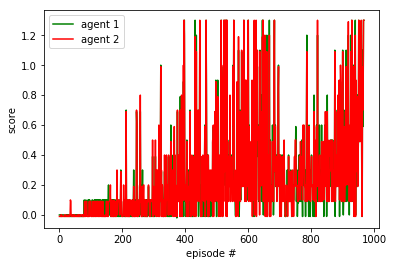

In [10]:
env = UnityEnvironment(file_name="Tennis.x86_64")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

agent_manager = AgentManager(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=1)
ddpg()

Test

In [9]:
env = UnityEnvironment(file_name="Tennis.x86_64")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)    

agent_manager = AgentManager(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=1)
agent_manager.load_models()

while True:
    actions = agent_manager.act(states, add_noise=False)          # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


/home/mexxik/.virtualenvs/drl-project-3/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Total score (averaged over agents) this episode: 2.600000038743019


### Results and Future Improvements.

This project is an example Deep Deterministic Policy Gradient (DDPG) algorithm implemented for Collaboration and Competition problem. Current implementation solved the enviroment in 968 episodes and shows consistent results during a test run.

During the training the agent was able to reach last score at 0.49 level on 400th episode and the quickly dropped to 0.25. It took some time recover and solve the task. Looks like this is an expected behaviour with a current implementation and a set of hyper-parameters.

Here are some possible improvements and exploration paths:
* Explore other algorithms, like PPO or more advances and modern like suggested in the lesson (Trust Region Policy Optimization (TRPO) and Truncated Natural Policy Gradient (TNPG),  Distributed Distributional Deterministic Policy Gradients (D4PG))
* Experiment with hyperparameters:
	* LEARN_EVERY and LEARN_NUM will allow to specify how ofter the network will be trained. Maybe try setting it to more "agressive" (frequest mode), even though it was reported that this approach was not stable.
	* Play with explotation/exploration by tweaking OU noise. OpenAI article suggest that OU might be not effective compared to mean-zero Gaussian noise.
	* Previous lessons and projects showed that experience buffer size affect on the performance.
	* Would be interesting to try increasing batch size for training and adding more regularization (L2) to avoid overfitting. 
	* This implementation does not enable epsilon parameter for decrease OU noise effect over time. Try uncommenting it for more experiements with exploration/exploitation.